In [2]:
import os, json, numpy as np, random, subprocess, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import Normalize

%matplotlib inline

In [3]:
path = "data"

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

from photutils import SegmentationImage
from pycocotools.mask import encode

In [6]:
import torch
torch.cuda.empty_cache()

### Convert grayscale images to gray RGB

Detectron2 takes inputs as RGB image files, scaled between 0 and 255. I want to preserve astronomical meaning instead of just normalizing the image, so:

* Add some value to the image so flux is non-negative
    * Use `2 x |min(img)|`
* Convert flux into magnitudes (range is approximately between 15 and 30)
* Rescale magnitudes: $X = 255 - 24 \times (M-15)$
    * Spans approximately between 0 and 255
    * Brighter objects have a higher value
* Use the same input in all 3 channels (R=G=B) to make a grayscale image



In [7]:
def mag_to_jpg(x, xmax, xmin):
    return 255 * (xmax - x) / (xmax - xmin)

def jpg_to_mag(y, xmax, xmin):
    return xmax - (y/255)*(xmax-xmin)

def flux_to_jpg(x, bg):   
    x          = x + bg
    x          = -2.5*np.log10(x)
    xmax, xmin = np.max(x), np.min(x)
    x          = mag_to_jpg(x, xmax, xmin)
    return x, xmax, xmin

def jpg_to_flux(x, bg, xmax, xmin):
    x = jpg_to_mag(x, xmax, xmin)
    x = np.power(10, -x/2.5)
    x = x - bg
    return x
    

In [8]:
# files  = ! ls {path}/raw
# # norm   = Normalize(vmin=-26.5, vmax=-19)

# bgs = []
# for f in files:
    
#     file = fits.open(f"{path}/raw/{f}")
#     img  = file[0].data
#     segm = file[1].data
    
#     bg   = 2*np.abs(np.min(img))
#     img, xmax, xmin  = flux_to_jpg(img, bg)
    
#     y, x = img.shape
#     new  = np.zeros((y, x, 3))
    
#     for i in range(3):
#         new[:,:,i] = img #norm(img, clip=True)
        
#     file.close()
        
#     new = Image.fromarray(np.array(new, dtype=np.uint8))
#     new.save(f"{path}/all/images/{f[:-5]}.jpg")
#     np.save(f"{path}/all/segmaps/{f[:-5]}.npy", segm)
#     bgs.append({"image" : f[:-5], "bg_mean" : bg, "xmax" : xmax, "xmin" : xmin})
    
# bgs = pd.DataFrame(bgs)
# bgs.to_csv(f"{path}/all/info.csv", index=False)

### Make validation set

Split into training and validation:

In [9]:
# ! rm -r {path}/val/images/* {path}/val/segmaps/* {path}/train/images/* {path}/train/segmaps/*

# files  = ! ls {path}/all/segmaps
# files  = [f[:-4] for f in files]
# valset = random.sample(files, int(0.2*len(files)))

# for f in valset:
#     os.system(f"cp {path}/all/segmaps/{f}.npy {path}/val/segmaps/{f}.npy")
#     os.system(f"cp {path}/all/images/{f}.jpg {path}/val/images/{f}.jpg")


# for f in (set(files) - set(valset)):
#     os.system(f"cp {path}/all/segmaps/{f}.npy {path}/train/segmaps/{f}.npy")
#     os.system(f"cp {path}/all/images/{f}.jpg {path}/train/images/{f}.jpg")
    

### Make a Detectron2 dataset registration function

In [10]:
def get_galaxies_dset(dset):
    
    # Files
    files = ! ls {path}/{dset}/images
    files = [f[:-4] for f in files]
    
    info       = pd.read_csv(f"{path}/all/info.csv")
    info["id"] = info["image"].astype(int)
    
    # Dataset dictionaries
    dataset_dicts = []
    for idx, f in enumerate(files):

        # Data for a single image
        impath = f"{path}/{dset}/images/{f}.jpg"
        imdata = plt.imread(impath)
        inf    = info[info.id == int(f)].iloc[0]
        
        entry = {}
        entry["file_name"] = impath
        entry["image_id"]  = idx
        entry["height"]    = imdata.shape[0]
        entry["width"]     = imdata.shape[1]
        entry["bg_mean"]   = inf["bg_mean"]
        entry["xmax"]      = inf["xmax"]
        entry["xmin"]      = inf["xmin"]
        entry["boxes"]     = np.array([entry["bg_mean"], entry["xmax"], entry["xmin"], 0])
        
        # Annotations
        segmap = np.load(f"{path}/{dset}/segmaps/{f}.npy")
        segmap = SegmentationImage(segmap)
        anns   = []
        for idx, l in enumerate(segmap.labels):
            
            bbox = segmap[idx].bbox
            larr = segmap.data == l
            larr = np.asarray(larr, order="F")
            
            anns.append({
                "bbox" : [bbox.ixmin, bbox.iymin, bbox.ixmax, bbox.iymax],
                "bbox_mode" : BoxMode.XYXY_ABS,
                "segmentation": encode(larr),
                "category_id" : 0
            })
        entry["annotations"] = anns
        dataset_dicts.append(entry)
    return dataset_dicts

Register the train and validation datasets

In [11]:
for d in ["train", "val"]:
#     DatasetCatalog.pop(f"gal_{d}")
    DatasetCatalog.register(f"gal_{d}", lambda d=d: get_galaxies_dset(d))
    MetadataCatalog.get(f"gal_{d}").set(thing_classes=["object"])
    
gal_metadata = MetadataCatalog.get("gal_train")

Look at the output with Detectron API

In [12]:
# plt.figure(figsize=(10,10))
# plt.imshow(img)

In [13]:
# dataset_dicts = get_galaxies_dset("train")

# imgs = []
# d = random.sample(dataset_dicts, 1)[0]
# img        = plt.imread(d["file_name"])
# visualizer = Visualizer(img, metadata=gal_metadata, scale=1)
# out        = visualizer.draw_dataset_dict(d)
# img_labelled = Image.fromarray(out.get_image())
# img_labelled

### Load config file from pre-trained model

In [14]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

Get the config file from the pre-trained model

In [15]:
# Initialize the config file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Datasets
cfg.DATASETS.TRAIN = ("gal_train", )
cfg.DATASETS.TEST = () #no test set
cfg.OUTPUT_DIR     = "galaxies/output"
cfg.INPUT.MASK_FORMAT = "bitmask"

### Build data augmenter

Data loader that allows image augmentation:

In [16]:
from detectron2.data import DatasetMapper, build_detection_train_loader, build_detection_test_loader
import detectron2.data.transforms as T
from scipy.stats import norm as gauss
from typing import Optional
from detectron2.data.transforms.augmentation import _check_img_dtype
from fvcore.transforms.transform import Transform
from astropy.convolution import convolve, Gaussian2DKernel

#### Adding noise

All of the training images are created so that the background noise level is 27 mag/arcsec$^2$. We can add extra noise:

\begin{equation}
    \sigma'^2 = 10^{-\frac{2M'}{2.5}} - 10^{-\frac{2\times27}{2.5}}
\end{equation}

Range the noise levels from 21 (SDSS-like) to 27 (Illustris).

In [17]:
class NoiseTransform(T.Transform):
    
    def __init__(self, noise, bgmean, xmax, xmin):
        super().__init__()
        self._set_attributes(locals())
        
    def apply_image(self, img: np.ndarray) -> np.ndarray:
        
        img_rgb   = np.zeros_like(img)
        img_flux  = jpg_to_flux(img[:, :, 0], self.bgmean, self.xmax, self.xmin)
        img_flux  += self.noise
        bg        = 2*np.abs(np.min(img_flux))        
        for i in range(3): img_rgb[:, :, i] = flux_to_jpg(img_flux, bg)[0]
            
        return img_rgb
    
    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        return coords
    
    
class NoiseAugmentation(T.Augmentation):
    def get_transform(self, image, boxes):
        bgmean, xmax, xmin, _    = boxes
        sky_sb    = 23 + 4*np.random.random(1)
        const     = np.power(10, -2/2.5)
        noise_add = np.power(const, sky_sb) - np.power(const, 27)
        noise_add = np.sqrt(noise_add)
        noise     = gauss.rvs(loc=0, scale=noise_add, size=image[:,:,0].shape)
        
        return NoiseTransform(noise, bgmean, xmax, xmin)


Test:

In [18]:
# augs    = T.AugmentationList([
#             NoiseAugmentation(), T.RandomContrast(0.5, 2)
#         ])
# input   = T.AugInput(plt.imread(d["file_name"]), boxes=np.array([d["bg_mean"], d["xmax"], d["xmin"], 0]))
# transform = augs(input)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(img)
# axs[1].imshow(transform.apply_image(img))

In [19]:
class PSFTransform(T.Transform):
    
    def __init__(self, kernel, bgmean, xmax, xmin):
        super().__init__()
        self._set_attributes(locals())
        
    def apply_image(self, img: np.ndarray) -> np.ndarray:
        
        img_rgb   = np.zeros_like(img)
        img_flux  = jpg_to_flux(img[:, :, 0], self.bgmean, self.xmax, self.xmin)
        img_conv  = convolve(img_flux, self.kernel)
        bg        = 2*np.abs(np.min(img_conv))   
        img_conv  = img_conv + bg
        
        for i in range(3): img_rgb[:, :, i] = flux_to_jpg(img_conv, bg)[0]
            
        return img_rgb
    
    def apply_coords(self, coords: np.ndarray) -> np.ndarray:
        return coords
    
    
class PSFAugmentation(T.Augmentation):
    def get_transform(self, image, boxes):
        bgmean, xmax, xmin, _    = boxes
        fwhm      = 1 + 5*np.random.random(1)
        kernel    = Gaussian2DKernel(fwhm)
        return PSFTransform(kernel, bgmean, xmax, xmin)



In [20]:
class RescaleAugmentation(T.Augmentation):
    def get_transform(self, image, boxes):
        
        scale      = 1+2*np.random.random()
        scale_down = True if np.random.random() < 0.5 else False
        
        h, w = image[:,:,0].shape
        if scale_down: 
            new_h, new_w = h/scale, w/scale
        else:
            new_h, new_w = h*scale, w*scale
        new_h, new_w = round(new_h), round(new_w)
        
        return T.ScaleTransform(h=h, w=w, new_h=new_h, new_w=new_w, interp="bicubic")




In [21]:
# temp = np.random.random(size=(100, 100, 3))

In [22]:
# augs    = RescaleAugmentation()
# # input   = T.AugInput(plt.imread(d["file_name"]), boxes=np.array([d["bg_mean"], d["xmax"], d["xmin"], 0]))
# input   = T.AugInput(temp, boxes=np.array([0,0,0,0]))
# transform = augs(input)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(temp)
# axs[1].imshow(transform.apply_image(temp))

In [23]:
import copy
from detectron2.data import detection_utils as utils

In [24]:
class MyAugData(T.AugInput):
    
    def transform(self, tfm: Transform) -> None:
        self.image = tfm.apply_image(self.image)
        if self.boxes is not None:
            self.boxes = self.boxes
        if self.sem_seg is not None:
            self.sem_seg = self.sem_seg #tfm.apply_segmentation(self.sem_seg)

In [25]:
class MyMapper(DatasetMapper):
    
    def __call__(self, dataset_dict):

        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
        utils.check_image_size(dataset_dict, image)

        boxes      = dataset_dict["boxes"]
        aug_input  = MyAugData(image=image, boxes=boxes)
        transforms = self.augmentations(aug_input)
        image, sem_seg_gt = aug_input.image, aug_input.sem_seg

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        if not self.is_train:
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.use_instance_mask:
                    anno.pop("segmentation", None)
                if not self.use_keypoint:
                    anno.pop("keypoints", None)

            
            annos = dataset_dict["annotations"]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.instance_mask_format
            )

            dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
        return dataset_dict

In [26]:
# augs    = T.AugmentationList([
#             NoiseAugmentation(), PSFAugmentation()
#         ])
# input   = MyAugData(plt.imread(d["file_name"]), boxes=np.array([d["bg_mean"], d["xmax"], d["xmin"], 0]))
# transform = augs(input)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(img)
# axs[1].imshow(transform.apply_image(img))

### Build a dataloader & trainer

In [27]:
from detectron2.engine import DefaultTrainer, SimpleTrainer

In [28]:
class MyTrainer(DefaultTrainer):
    
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg, 
            mapper  = MyMapper(cfg, is_train=True, augmentations=[
                                NoiseAugmentation(), PSFAugmentation()]
#                                 T.RandomFlip(horizontal=True, vertical=False), 
#                                 T.RandomFlip(horizontal=False, vertical=True),
#                                 T.RandomRotation([0, 360], sample_style="range")
#                                 ]
                           ))
#         total_batch_size = 512,
#         num_workers      = 16


In [29]:
# Loading data 
cfg.DATALOADER.NUM_WORKERS = 4

# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

# Parameters??
cfg.SOLVER.IMS_PER_BATCH = 5     # Images per batch
cfg.SOLVER.BASE_LR       = 0.00025     # Learning rate
cfg.SOLVER.MAX_ITER      = 600        # Iterations; need more for real data
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Batch size - default is 512; this is faster
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [30]:
trainer = MyTrainer(cfg)

[12/09 00:15:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/09 00:15:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [<__main__.NoiseAugmentation object at 0x7fbe37635908>, <__main__.PSFAugmentation object at 0x7fbe3765cdd8>]
[12/09 00:15:29 d2.data.build]: Removed 0 images with no usable annotations. 240 images left.
[12/09 00:15:29 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   object   | 7912         |
|            |              |
[12/09 00:15:29 d2.data.build]: Using training sampler TrainingSampler
[12/09 00:15:29 d2.data.common]: Serializing 240 elements to byte tensors and concatenating them all ...
[12/09 00:15:29 d2.data.common]: Serialized dataset takes 1.49 MiB


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [31]:
trainer.train()

[12/09 00:15:30 d2.engine.train_loop]: Starting training from iteration 0


/home/jovyan/.local/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[12/09 00:15:47 d2.utils.events]:  eta: 0:07:48  iter: 19  total_loss: 100.1  loss_cls: 41.57  loss_box_reg: 15.04  loss_mask: 1.482  loss_rpn_cls: 3.55  loss_rpn_loc: 17.85  time: 0.8108  data_time: 0.4917  lr: 4.9953e-06  max_mem: 3535M
[12/09 00:16:04 d2.utils.events]:  eta: 0:07:37  iter: 39  total_loss: 18.94  loss_cls: 8.908  loss_box_reg: 4.155  loss_mask: 0.5591  loss_rpn_cls: 0.9032  loss_rpn_loc: 2.626  time: 0.8350  data_time: 0.4989  lr: 9.9902e-06  max_mem: 3729M
[12/09 00:16:20 d2.utils.events]:  eta: 0:07:12  iter: 59  total_loss: 4.575  loss_cls: 0.986  loss_box_reg: 0.815  loss_mask: 0.5581  loss_rpn_cls: 0.6258  loss_rpn_loc: 1.318  time: 0.8214  data_time: 0.4046  lr: 1.4985e-05  max_mem: 3803M
[12/09 00:16:39 d2.utils.events]:  eta: 0:06:59  iter: 79  total_loss: 2.905  loss_cls: 0.4383  loss_box_reg: 0.5034  loss_mask: 0.5395  loss_rpn_cls: 0.5181  loss_rpn_loc: 0.8431  time: 0.8476  data_time: 0.5375  lr: 1.998e-05  max_mem: 3931M
[12/09 00:16:56 d2.utils.events]:

In [ ]:
# torch.cuda.empty_cache()

### Results

In [32]:
from detectron2.engine import DefaultPredictor

In [41]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold


In [42]:
predictor = DefaultPredictor(cfg)

In [ ]:
val_dict = get_galaxies_dset("val")

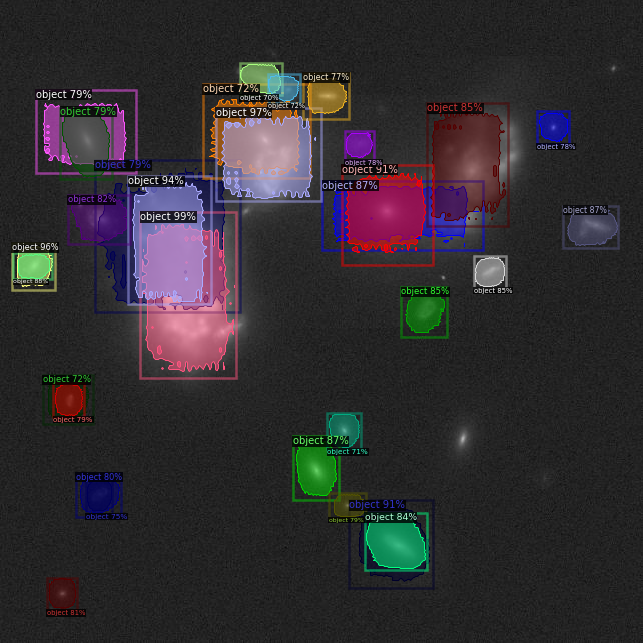

In [47]:

d   = random.sample(val_dict, 1)[0]
im  = plt.imread(d["file_name"])

# im.shape
outputs = predictor(im)
v   = Visualizer(im, metadata=gal_metadata, scale=1)#0.5)#, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())

In [48]:
from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval

stretch_r = AsinhStretch(1)
stretch_g = AsinhStretch(1)
stretch_b = AsinhStretch(1)

norm_b = AsymmetricPercentileInterval(0.1, 99.9)
norm_g = AsymmetricPercentileInterval(0.1, 99.7)
norm_r = AsymmetricPercentileInterval(0.1, 98.5)

In [50]:
im = plt.imread("data/test/sdss.jpg")
im = im[:,:,0]
r = np.uint8( stretch_r(norm_r(im)) * 255)
g = np.uint8( stretch_g(norm_g(im)) * 255)
b = np.uint8( stretch_b(norm_b(im)) * 255)
            
img    = np.array([r, g, b])
img    = np.swapaxes(img, 0, 2)
img    = np.swapaxes(img, 0, 1)
img.shape

(992, 1014, 3)

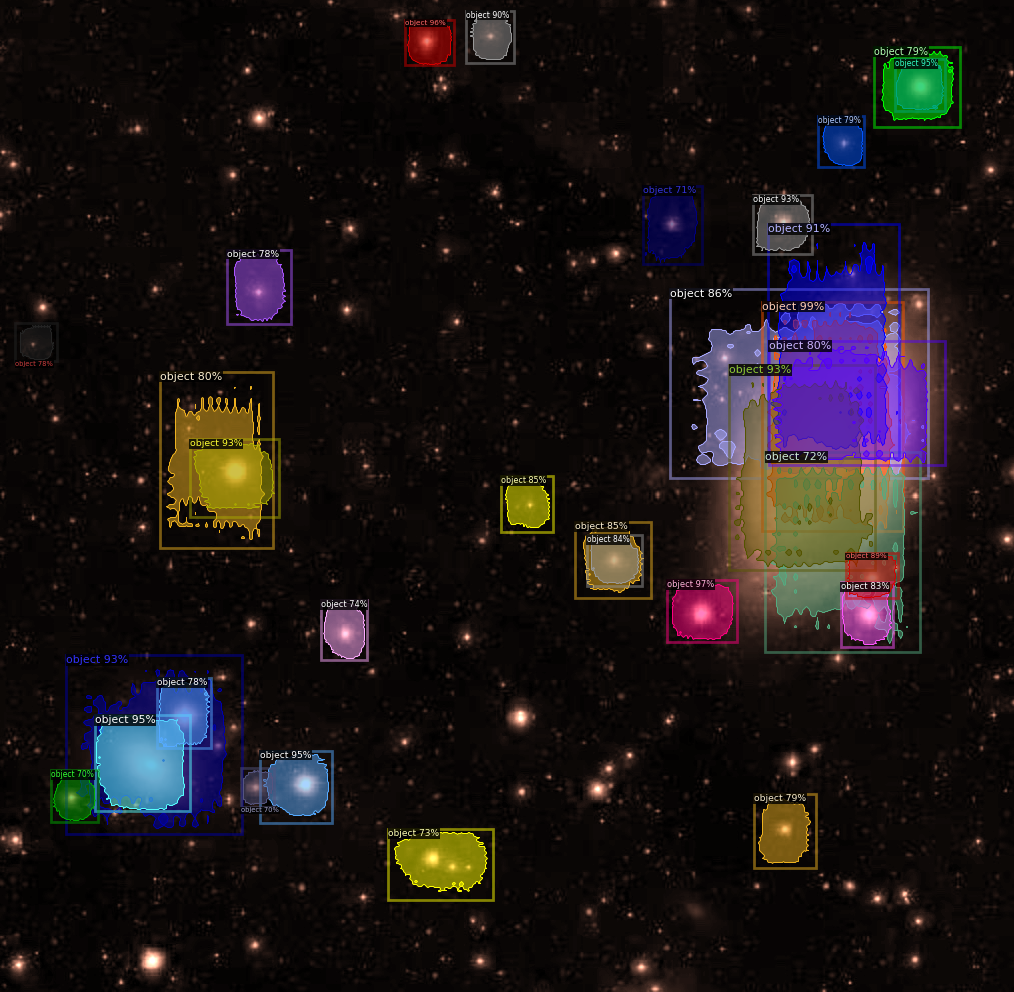

In [51]:
# im = plt.imread("galaxies/test/sdss.jpg")
# d   = random.sample(dataset_dicts, 1)[0]
# im  = plt.imread(d["file_name"])
outputs = predictor(img)
v   = Visualizer(img, metadata=gal_metadata, scale=1)#0.5)#, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image())